In [1]:
!kaggle competitions download -c bike-sharing-demand

403 - Forbidden


In [45]:
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
import torch.utils.data as data_utils


import pandas as pd
import numpy as np

import sklearn
from sklearn.model_selection import train_test_split

import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import numpy as np
import seaborn as sns
from IPython.display import clear_output, display

np.set_printoptions(precision=2)
plt.rcParams['figure.figsize'] = (14.0, 10.0)


In [46]:
def load_data(preprocess = True):
    train_df = pd.read_csv('./bike-sharing-demand/train.csv')
    test_df = pd.read_csv('./bike-sharing-demand/test.csv')

    def _add_datetime_cols(df):
        df['datetime'] = pd.to_datetime(df['datetime'])
        df['year'] = pd.DatetimeIndex(df['datetime']).year
        df['day'] = pd.DatetimeIndex(df['datetime']).day
        df['month'] = pd.DatetimeIndex(df['datetime']).month
        df['hour'] = pd.DatetimeIndex(df['datetime']).hour
        df['dayofweek'] = pd.DatetimeIndex(df['datetime']).dayofweek
        
        df.set_index('datetime')

        return df

    def _preprocess(df):
        # drop columns which don't exist in test-set
        cols_to_drop = ['registered', 'casual']
        for ctd in cols_to_drop:
            if ctd in df.columns:
                df = df.drop(ctd, axis = 1)

        if 'count' in df.columns:
            print('Removing outliers')
            cutoff_factor = 3
            print('Before removal', df.shape, df['count'].mean(), df['count'].std(), df['count'].max(), df['count'].min())
            df = df[abs(df['count'] - df['count'].mean()) < cutoff_factor*df['count'].std()]
            df.reset_index(drop = True, inplace = True)
            print('After removal', df.shape, df['count'].mean(), df['count'].std(), df['count'].max(), df['count'].min())

            print('Log transform applied to count column')
            df[target_col] = df[target_col].apply(lambda x: np.log(x + 1))

            
        return df
        
    train_df = _add_datetime_cols(train_df)
    test_df = _add_datetime_cols(test_df)

    if preprocess:
        train_df = _preprocess(train_df)
        test_df = _preprocess(test_df)      
    
    return train_df, test_df

train_df, test_df = load_data(preprocess=False)
print(train_df.shape, test_df.shape)

(10886, 17) (6493, 14)


In [251]:
print(train_df.isnull().sum(axis = 0))
print(test_df.isnull().sum(axis = 0))

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
year          0
day           0
month         0
hour          0
dayofweek     0
dtype: int64
datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
year          0
day           0
month         0
hour          0
dayofweek     0
dtype: int64


In [252]:
train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,day,month,hour,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,5


In [253]:
display(round(train_df.describe(), 2))

# for s in range(1, 5):
#     display(round(df[train_df['season'] == s].describe(), 2))

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,day,month,hour,dayofweek
count,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00,10886.0,10886.00,10886.00,10886.00,10886.00
mean,2.51,0.03,0.68,1.42,20.23,23.66,61.89,12.80,36.02,155.55,191.57,2011.5,9.99,6.52,11.54,3.01
std,1.12,0.17,0.47,0.63,7.79,8.47,19.25,8.16,49.96,151.04,181.14,0.5,5.48,3.44,6.92,2.00
min,1.00,0.00,0.00,1.00,0.82,0.76,0.00,0.00,0.00,0.00,1.00,2011.0,1.00,1.00,0.00,0.00
25%,2.00,0.00,0.00,1.00,13.94,16.66,47.00,7.00,4.00,36.00,42.00,2011.0,5.00,4.00,6.00,1.00
50%,3.00,0.00,1.00,1.00,20.50,24.24,62.00,13.00,17.00,118.00,145.00,2012.0,10.00,7.00,12.00,3.00
75%,4.00,0.00,1.00,2.00,26.24,31.06,77.00,17.00,49.00,222.00,284.00,2012.0,15.00,10.00,18.00,5.00
max,4.00,1.00,1.00,4.00,41.00,45.46,100.00,57.00,367.00,886.00,977.00,2012.0,19.00,12.00,23.00,6.00


### Histograms for each column, correlation map, pairwise plots

<Figure size 1008x720 with 0 Axes>

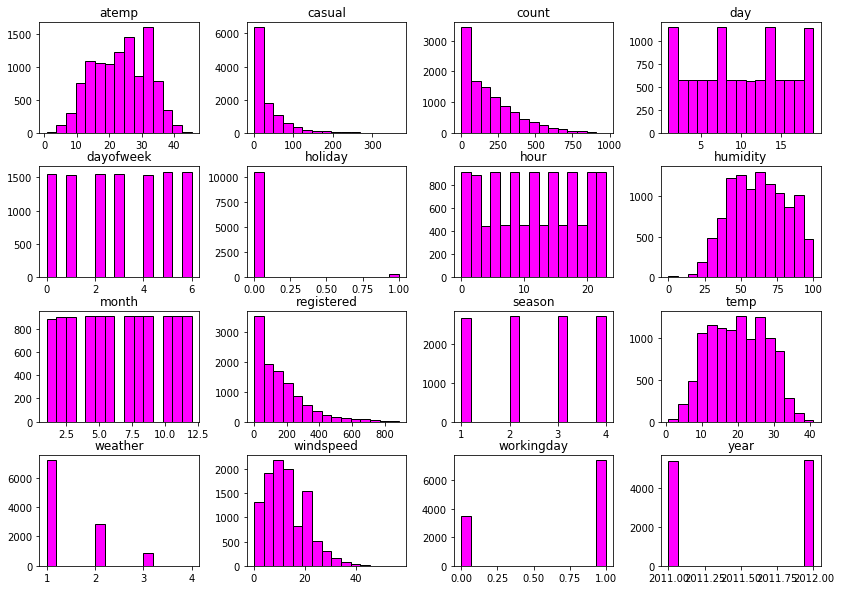

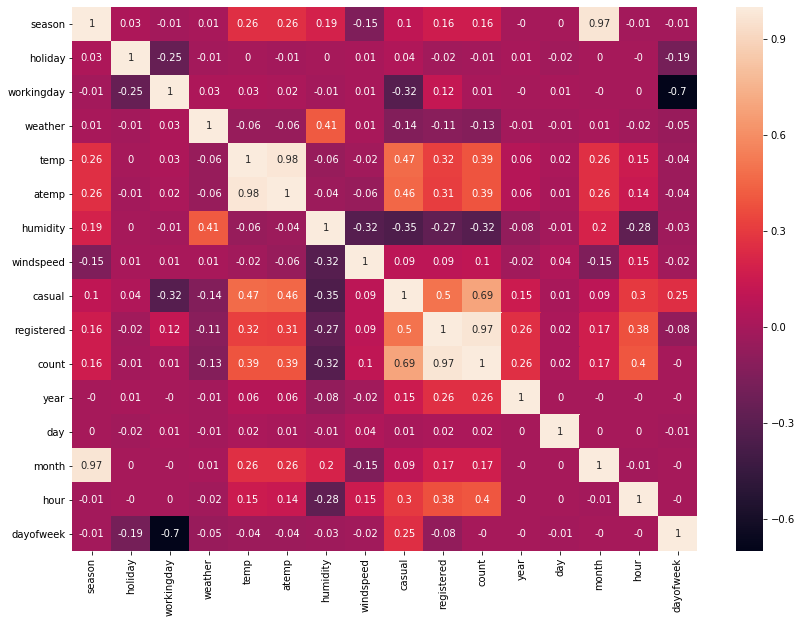

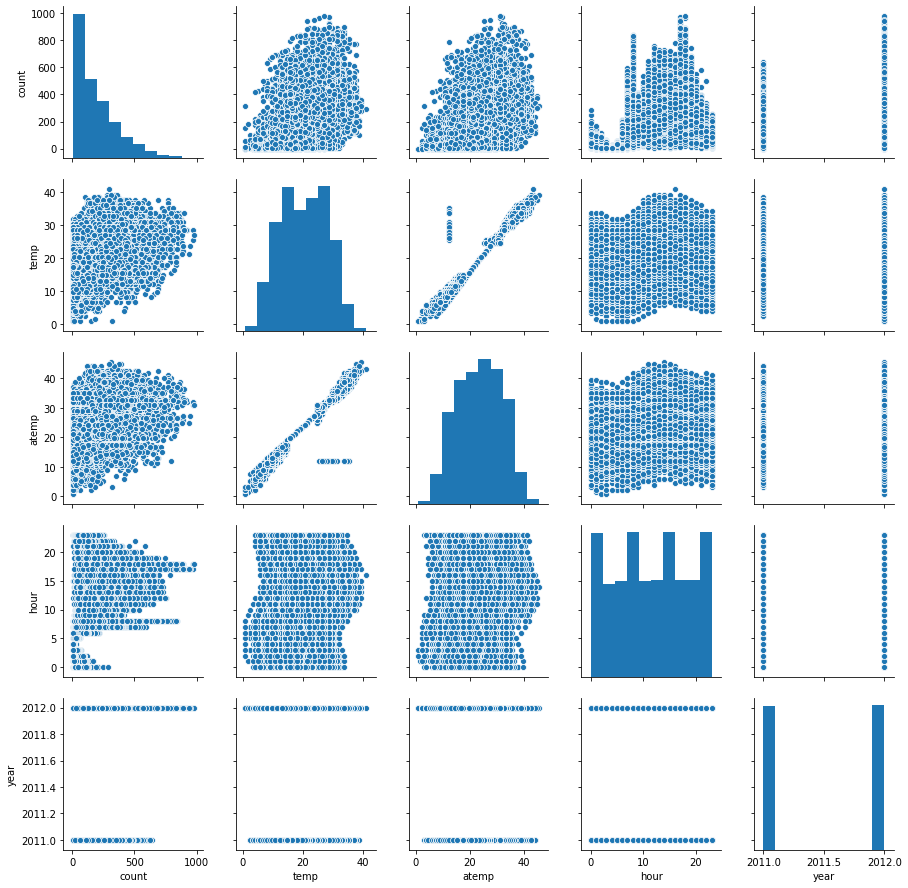

In [254]:
plt.figure()
train_df.hist(bins=15, color='magenta', edgecolor='black', grid=False)

plt.figure()
corr = train_df.corr()
sns.heatmap(round(corr,2), annot=True)

sns.pairplot(train_df[['count', 'temp', 'atemp', 'hour', 'year']])

### Explore target variable

- outliers
- skewed distribution
- log transformed distribution

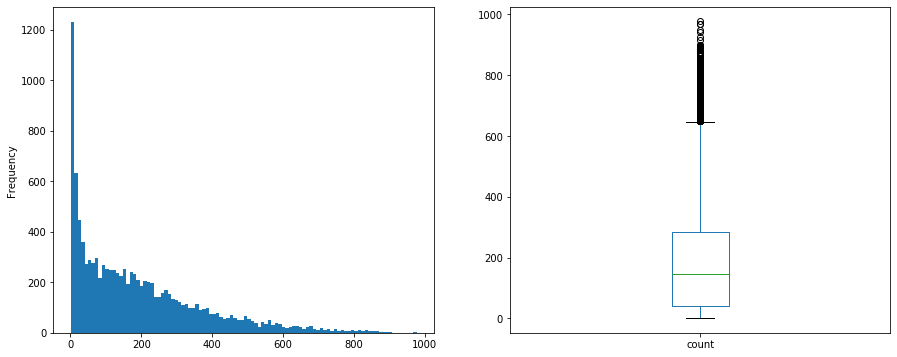

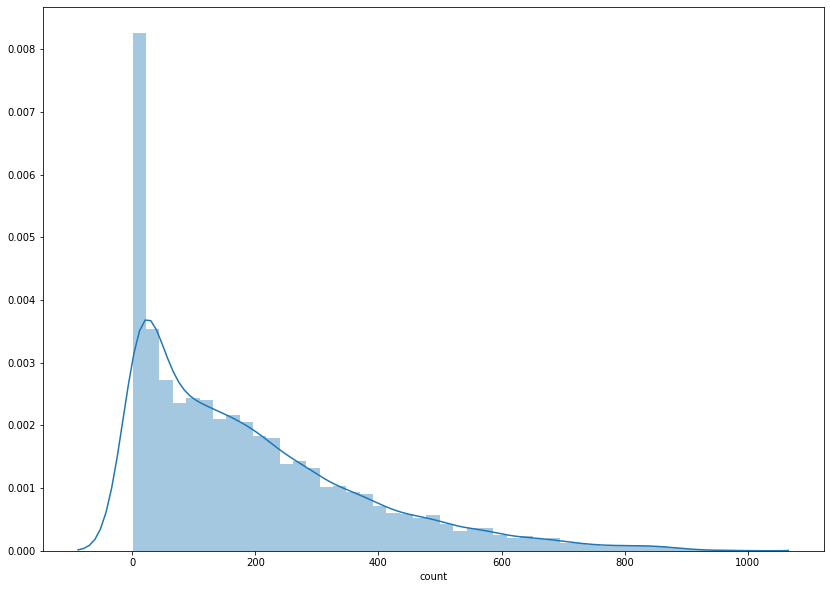

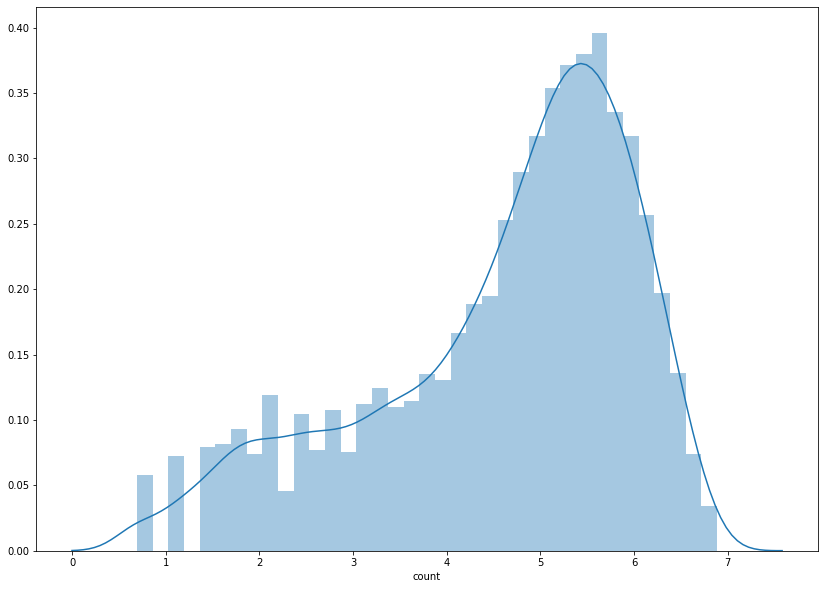

In [159]:
fig,ax = plt.subplots(1, 2, figsize=(15,6))
train_df['count'].plot(kind = 'hist', bins=100, ax = ax[0])
train_df['count'].plot(kind = 'box', ax = ax[1])

plt.figure()
sns.distplot(train_df['count'])
plt.figure()
sns.distplot(train_df['count'].apply(lambda x: np.log(x + 1)))

###  Windspeed

- windspeed has suspicious amonut of zeros and no values between 0 to 6
- distribution smoothened with rolling average removes some amonut of zeros

windspeed
0.0000     1313
6.0032      872
7.0015     1034
8.9981     1120
11.0014    1057
12.9980    1042
15.0013     961
16.9979     824
19.0012     676
19.9995     492
22.0028     372
23.9994     274
26.0027     235
27.9993     187
30.0026     111
31.0009      89
32.9975      80
35.0008      58
36.9974      22
39.0007      27
40.9973      11
43.0006      12
43.9989       8
46.0022       3
47.9988       2
50.0021       1
51.9987       1
56.9969       2
Name: count, dtype: int64

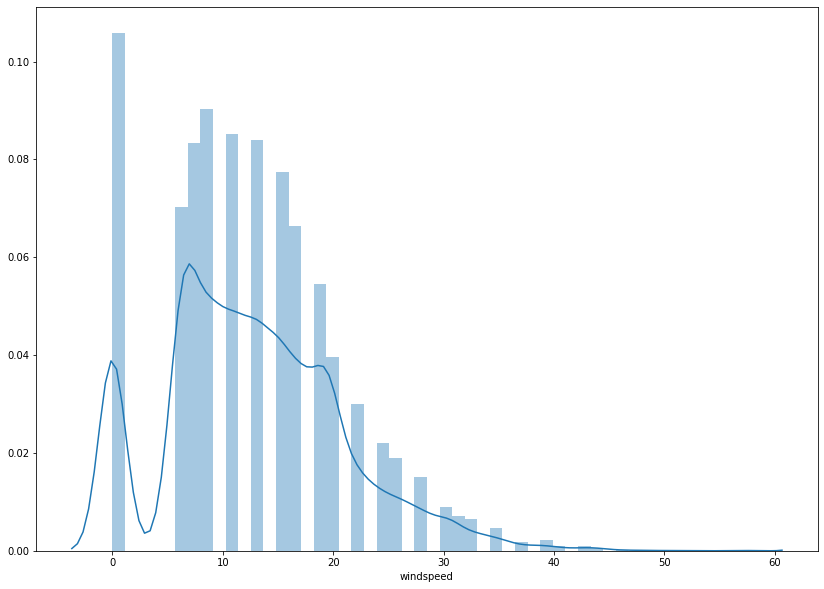

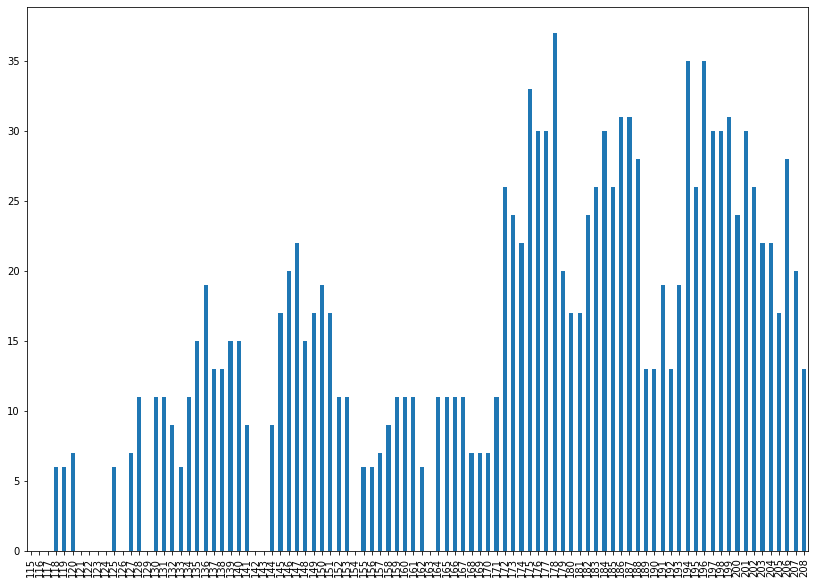

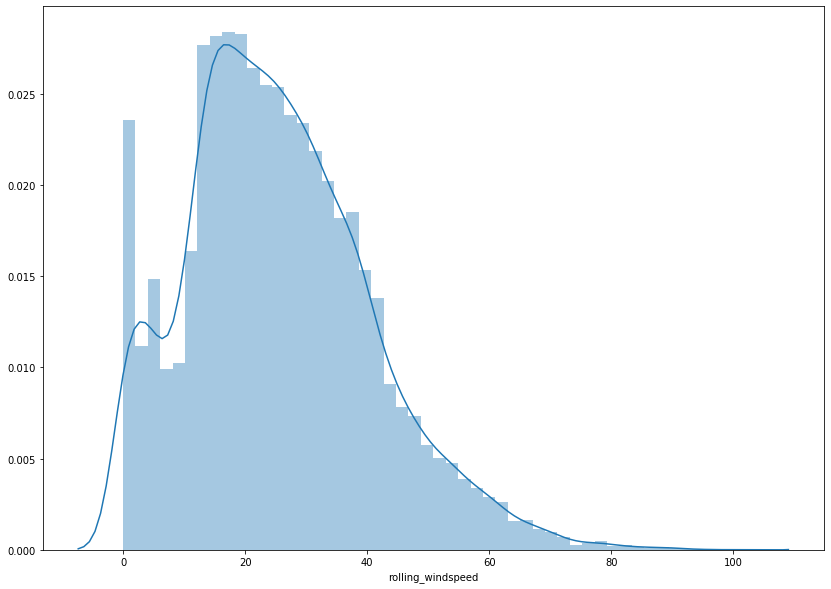

In [235]:

plt.figure()
sns.distplot(train_df['windspeed'])

plt.figure()
train_df[(train_df['month'] == 1) & (train_df['year'] == 2011) & (train_df['day'] < 10) & (train_df['day'] > 5)] \
['windspeed'].plot(kind='bar')

display(train_df.groupby('windspeed')['count'].count())

train_df['rolling_windspeed'] = train_df['windspeed'] + train_df['windspeed'].rolling(3, center=False, min_periods=1).mean()
plt.figure()
sns.distplot(train_df['rolling_windspeed'])

### Month == season 

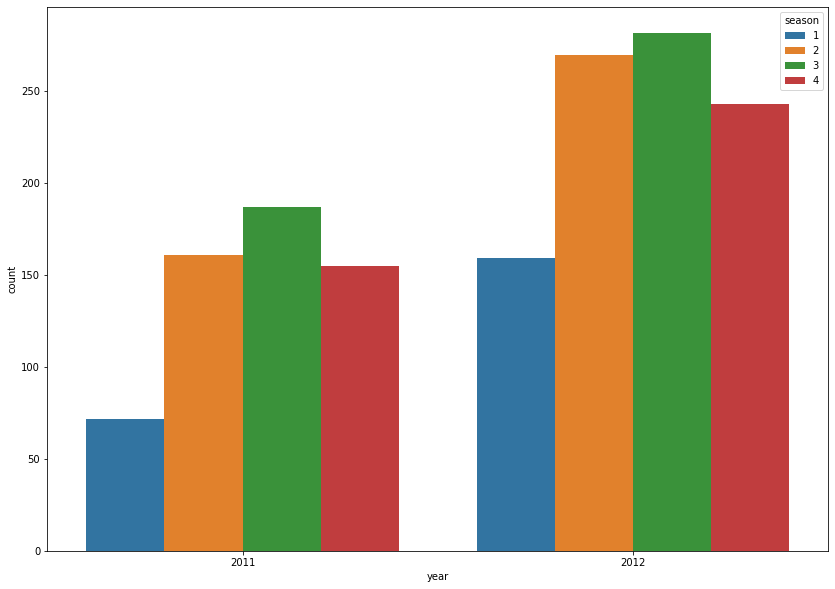

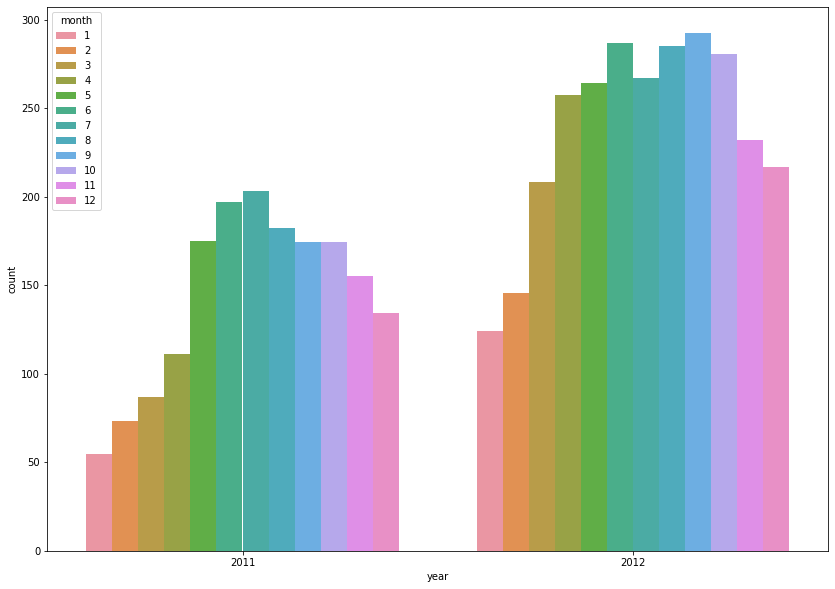

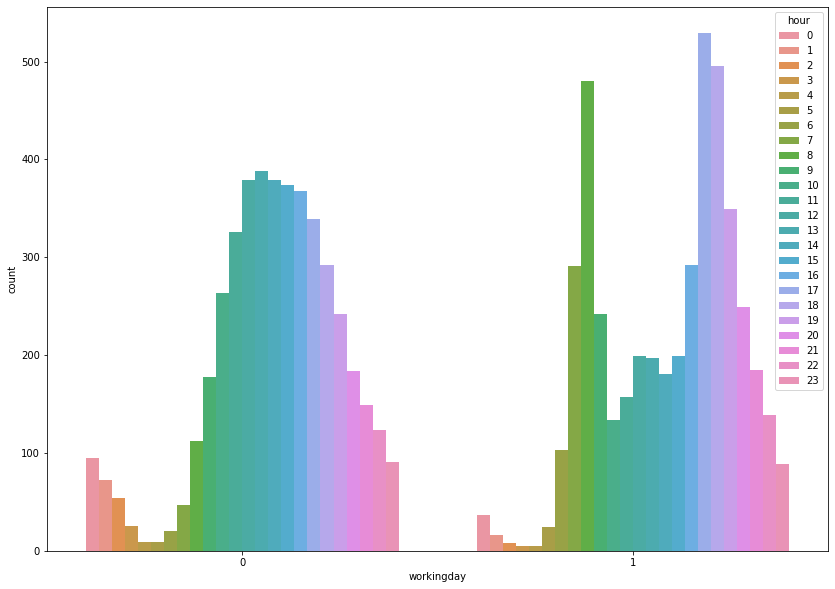

In [122]:
plt.figure()
sns.barplot('year', 'count', hue='season', data=train_df, ci=None)

plt.figure()
sns.barplot('year', 'count', hue='month', data=train_df, ci=None)

plt.figure()
sns.barplot('workingday', 'count', hue='hour', data=train_df, ci=None)

### Check high correlation between temp and atemp

<Figure size 1008x720 with 0 Axes>

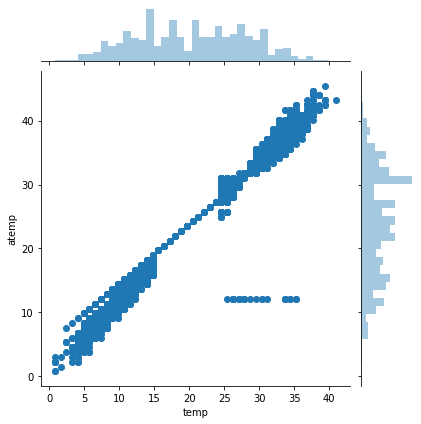

In [121]:
plt.figure()
sns.jointplot(x='temp', y='atemp', data=train_df) 

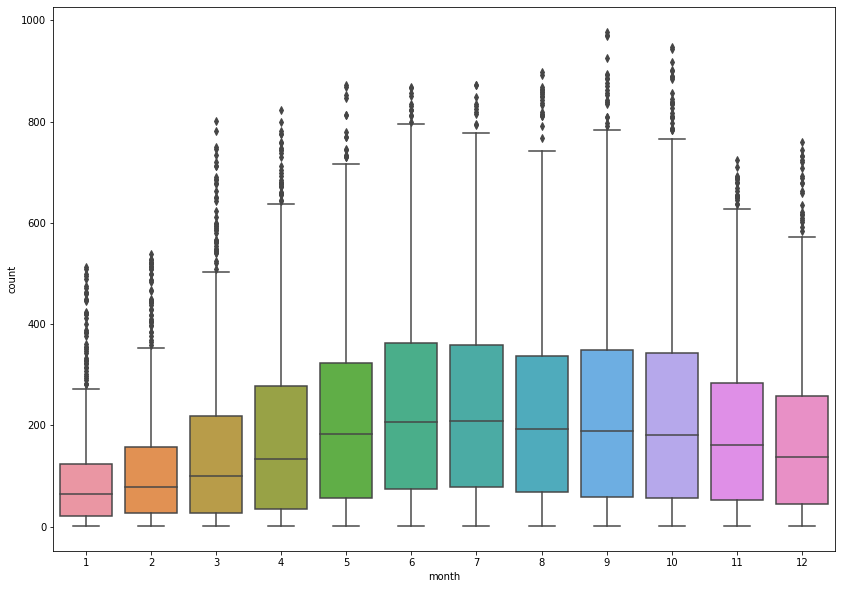

In [135]:
sns.boxplot(x='month', y='count', data=train_df)

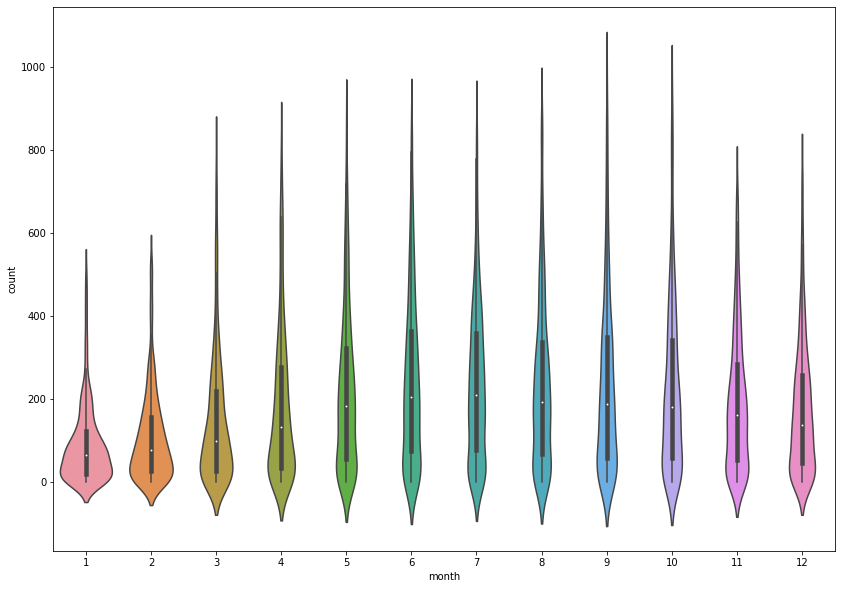

In [137]:
sns.violinplot(x='month', y='count', data=train_df)

## Training

In [69]:
bs = 256
valid_vs = 4096
test_size = 0.2

target_col = ['count']
cont_cols = ['windspeed', 'humidity', 'temp']
cat_cols = ['holiday', 'workingday', 'year', 'weather', 'month', 'dayofweek', 'hour']

train_df, test_df = load_data()

def one_hot_encode(df, cat_cols):
    cat_cols_one_hot = []
    for col in cat_cols:
        one_hot = pd.get_dummies(df[col], prefix=col)
        cat_cols_one_hot.append(one_hot.columns.tolist())
        df = df.drop(col, axis = 1)
        df = df.join(one_hot)
        
    return df, cat_cols_one_hot

def normalize(df, cont_cols, normalization_params = None):
    if normalization_params:
        std = normalization_params['std']
        mean = normalization_params['mean']
    else:
        std = df[cont_cols].std()
        mean = df[cont_cols].mean()

    df[cont_cols] = (df[cont_cols] - mean) / std
    
    return df, { "mean": mean, "std": std }

def delog(x):
    x = x.numpy().squeeze()
    x = np.clip(np.e**x - 1, 0, None)
    return x

def select_features(df, cont_cols, cat_cols_one_hot):
    feature_cols = cont_cols + [item for sublist in cat_cols_one_hot for item in sublist]

    return df[feature_cols]

train_df, cat_cols_one_hot = one_hot_encode(train_df, cat_cols)
test_df, cat_cols_one_hot = one_hot_encode(test_df, cat_cols)
train_df, normalization_params = normalize(train_df, cont_cols)
test_df, normalization_params = normalize(test_df, cont_cols, normalization_params)

train_features_df = select_features(train_df, cont_cols, cat_cols_one_hot)
train_target_df = train_df[target_col]

test_features_df = select_features(test_df, cont_cols, cat_cols_one_hot)



x_train, x_valid, y_train, y_valid = train_test_split(train_features_df, train_target_df, test_size=test_size)
x_train_tensor = torch.tensor(x_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
x_valid_tensor = torch.tensor(x_valid.values, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.float32)

x_test_tensor = torch.tensor(test_features_df.values, dtype=torch.float32)

train_data = data_utils.TensorDataset(x_train_tensor, y_train_tensor)
train_loader = data_utils.DataLoader(train_data, batch_size=bs, shuffle=True)

valid_data = data_utils.TensorDataset(x_valid_tensor, y_valid_tensor)
valid_loader = data_utils.DataLoader(valid_data, batch_size=valid_vs, shuffle=True)

print(x_train.shape, x_valid.shape, y_train.shape, y_valid.shape, x_test_tensor.shape)

Removing outliers
Before removal (10886, 15) 191.57413191254824 181.14445383028496 977 1
After removal (10739, 15) 183.00381786013594 166.68142883624617 734 1
Log transform applied to count column
(8591, 56) (2148, 56) (8591, 1) (2148, 1) torch.Size([6493, 56])


In [54]:
display(train_target_df.describe())
train_features_df.head()

,count
count,10739.000000
mean,4.562424
std,1.407248
min,0.693147
25%,3.737670
50%,4.955827
75%,5.624018
max,6.599870


,windspeed,humidity,temp,holiday_0,holiday_1,workingday_0,workingday_1,year_2011,year_2012,weather_1,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,-1.564997,0.984877,-1.323100,1,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,-1.564997,0.932905,-1.428532,1,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,-1.564997,0.932905,-1.428532,1,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,-1.564997,0.673048,-1.323100,1,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,-1.564997,0.673048,-1.323100,1,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [57]:
import math

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb_config = []
        self.cat_cols_one_hot = cat_cols_one_hot
        self.cont_cols = cont_cols
        
        self.emb_sizes = []

        for c in cat_cols_one_hot:
            name = c[0].split('_')[0]
            in_features = len(c)
            out_features = math.ceil(len(c)/2)+1
            
            self.emb_sizes.append(out_features)
            self.emb_config.append({
                "name": name,
                "out_features": out_features,
                "in_features": in_features,
            })

            setattr(self, name, nn.Sequential(
                nn.Linear(in_features, out_features)
            ))
            
        head_input_features = sum(self.emb_sizes) + len(cont_cols)

        self.head = nn.Sequential(
            nn.BatchNorm1d(head_input_features),
            nn.Linear(head_input_features, 64),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        ) 
    
        
        for n, l in self.named_parameters():
            if l.dim() == 1:
                nn.init.constant_(l, 0.01)
            else:
                nn.init.kaiming_uniform_(l, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        emb_in_features_count = 0 
        emb_output = []

        for config in self.emb_config:
            emb_layer = getattr(self, config['name'])
            start = emb_in_features_count
            end = emb_in_features_count + config['in_features']
            emb_x = x[:, start:end]
            
            emb_output.append(emb_layer(emb_x))
            emb_in_features_count += config['in_features']
        
        x = torch.cat(emb_output + [x[:, end:]], dim=1)
        x = self.head(x)
        
        return x * 8 # limit the network output

model = Model()
loss_fn = nn.MSELoss(reduction='mean')

   epoch            lr  train_loss  valid_loss        r2
0    0.0  1.000000e-02    0.305514    0.402818  0.807876
0    1.0  1.000000e-02    0.219356    0.172380  0.917784
0    2.0  1.000000e-02    0.144272    0.172057  0.917938
0    3.0  1.000000e-02    0.170603    0.156548  0.925334
0    4.0  1.000000e-02    0.223716    0.156589  0.925315
0    5.0  1.000000e-03    0.098330    0.117887  0.943774
0    6.0  1.000000e-03    0.177825    0.114083  0.945588
0    7.0  1.000000e-03    0.119284    0.118733  0.943370
0    8.0  1.000000e-03    0.147624    0.116918  0.944236
0    9.0  1.000000e-04    0.147334    0.113374  0.945926
0   10.0  1.000000e-04    0.178819    0.115453  0.944935
0   11.0  1.000000e-04    0.198689    0.113577  0.945830
0   12.0  1.000000e-04    0.102498    0.112840  0.946181
0   13.0  1.000000e-05    0.177838    0.114446  0.945415
0   14.0  1.000000e-05    0.158394    0.112329  0.946425
0   15.0  1.000000e-05    0.177251    0.113801  0.945723
0   16.0  1.000000e-05    0.148

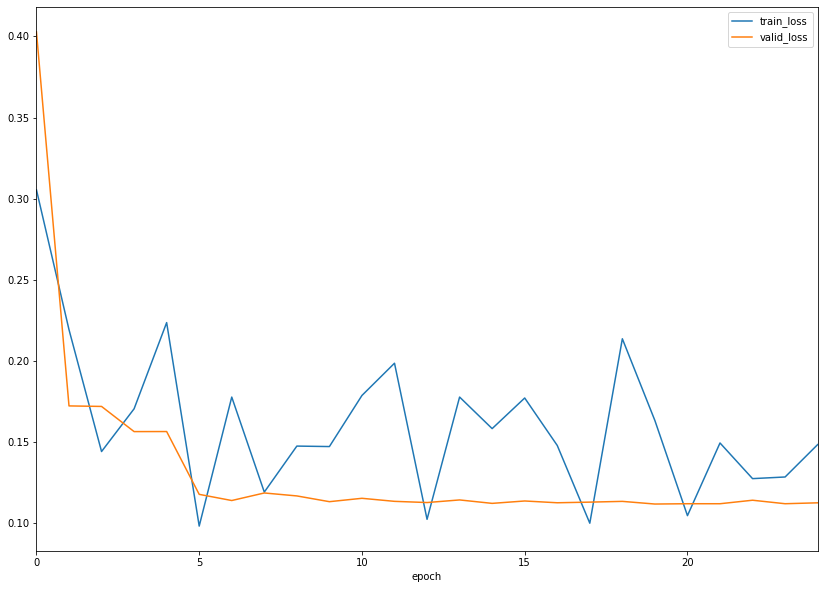

In [58]:
RESET_TRAINING_STATS = True
epochs = 25
lr = 1e-4
fig, ax = plt.subplots()


lrs = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-2)

if RESET_TRAINING_STATS:
    training_stats = pd.DataFrame({
        "epoch": [],
        "lr": [],
        "train_loss": [],
        "valid_loss": [],
        "r2": []
    })
    training_stats.set_index('epoch')

prev_lr_idx = -1
for epoch in range(epochs):
    lr_idx = int(epoch/epochs*len(lrs))

    if lr_idx != prev_lr_idx:
        lr = lrs[lr_idx]
        prev_lr_idx = lr_idx
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    
    for batch_no, (xt, yt) in enumerate(train_loader):
        yt_hat = model(xt)
        loss = loss_fn(yt_hat, yt)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        
    if epoch % 1 == 0:
        with torch.no_grad():
            model.eval()

            for xv, yv in valid_loader:
                yv_hat = model(xv)
                valid_loss = loss_fn(yv_hat, yv)
                valid_r2 = sklearn.metrics.r2_score(yv, yv_hat)

            model.train()

    training_stats = training_stats.append(pd.DataFrame({
        "epoch": [epoch],
        "lr": [lr],
        "train_loss": [loss.item()],
        "valid_loss": [valid_loss.item()],
        "r2": [valid_r2]
    }), sort=False)
    
print(training_stats)
    
if len(training_stats) > 1:
    training_stats.plot(kind='line', x='epoch', y=['train_loss', 'valid_loss'], ax=ax)

In [71]:
with torch.no_grad():
    model.eval()

    for xv, yv in valid_loader:
        yv_hat = model(xv)
        loss = loss_fn(yv_hat, yv)
        print('valid_loss: ', loss.item())
        print('r2: ', sklearn.metrics.r2_score(yv, yv_hat))

    yv_hat = yv_hat.numpy()
    yv = yv.numpy()

    print(yv.shape, yv_hat.shape)

    df = pd.DataFrame(data=np.concatenate([yv_hat, yv, (yv_hat - yv)**2], axis = 1))

df

valid_loss:  0.09972665458917618
r2:  0.9491048056663672
(2148, 1) (2148, 1)


,0,1,2
0,4.440761,4.912655,0.222684
1,3.007067,2.708050,0.089411
2,4.781202,4.744932,0.001316
3,3.199258,3.332205,0.017675
4,2.012337,1.386294,0.391930
...,...,...,...
2143,3.650775,4.158883,0.258174
2144,3.717535,3.663562,0.002913
2145,5.575019,5.472270,0.010557
2146,4.395646,4.584968,0.035843


### Sumbission (test set)

In [63]:
with torch.no_grad():
    model.eval()
    y_hat = model(x_test_tensor)
    y_hat = delog(y_hat)
    df = pd.DataFrame(data = {"datetime": test_df['datetime'], "count": y_hat })
    
df.to_csv('./submission.csv', index=False)

In [293]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "log transfomed target, trained with valid, fixed inverse log transform"

100%|████████████████████████████████████████| 188k/188k [00:09<00:00, 20.6kB/s]
Successfully submitted to Bike Sharing Demand